In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize': (12,4)})

#### Repeatable random: Always set a seed!

In [5]:
import numpy as np
np.random.seed(17)

# Input for the Machine Learning Problem

We want to train an artificial neural network to trade in a synthetic market. And for that, we need to produce arbitrary amounts of data. That's what we do in this notebook.

### Prerequisites
In our experiment, we call 256 business days a year. GPUs are most efficient to chew on chunks with sizes of powers of two, that's why. Since we decided to study a synthetic case, that is not a limitation. Funny enough - it's quite close to reality, too.

## The Market

The input shall be some recent history of market prices and a vector of current weights of our portfolio, the latter including a cash position. This history of market prices is what we will create with the help of a synthetic stock market model here.

This is a short summary of the synthetic market model. For more in-depth discussions, see [Market_with
_Inertia.ipynb](Market_with_Inertia.ipynb)

## Modelling Stocks
Here, we create a bunch of random stocks with a little helper function.

A stock is an object that has a sentiment attached to it. A sentiment is basically a function over time that consists of non-continous linear sections, as you can see below. This sentiment function is denoted by $\phi(t)$ or ```phi(t)```

In [6]:
from markets.stocks_model import create_stocks
from markets.dynamic_market import Stock

stocks = create_stocks(10)

ticker = list(stocks.keys())[0]
stock = stocks[ticker]
ticker

'ISCR'

#### Stock Sentiment
Here's the stock's own sentiment. The discontinuities, occuring quarterly, shall be thought of as earnings surprises from the quarterly reports.

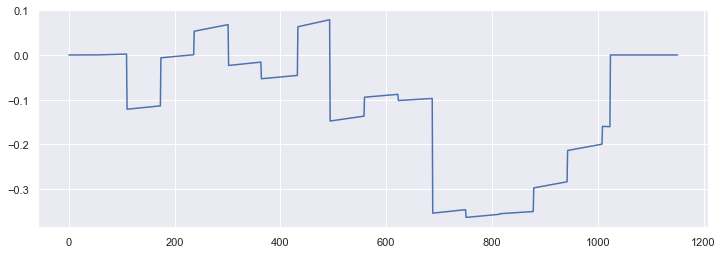

In [7]:
plt.plot([stock.phi(t) for t in range(1152)]);

#### Exposure to market segments (industries)
We model the exposure of a stock to selection of industries as a map of a ```Segment``` that has 
an exposure factor associated with it. In our example, we model exposure to a single segment, namely the IT industry. In case you wonder: This *exposure* is closely related to what we call *beta*. It is effectively the underlying prior that determines the beta - in our model, not necessarily in the real world.

In [8]:
segment = list(stock.segments.keys())[0]

In [9]:
segment.name

'Information Technology'

In [10]:
exposure = stock.segments[segment]
exposure

-0.5048371942801054

A segment also has a sentiment associated with it. In our setup, the IT market is essentially getting higher and higher sentiment. 

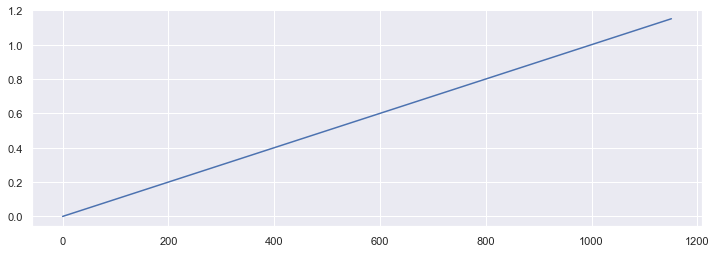

In [11]:
plt.plot([segment.phi(t) for t in range(1152)]);

#### Exposure to geo markets
We model the exposure of a stock to selection of geo markets as a map of a ```GeoMarket```s that has just another exposure factor associated with it. In our example, we model exposure to a single geo market, namely the US.

In [12]:
geo_market = list(stock.markets.keys())[0]

In [13]:
geo_market.name

'US'

In [14]:
exposure = stock.markets[geo_market]
exposure

0.25662886200037893

A geo market also has a sentiment associated with it. In our setup, the US market is pretty shaky for some time but then takes off like crazy (That'd be after the end of the trade war in real life, maybe).

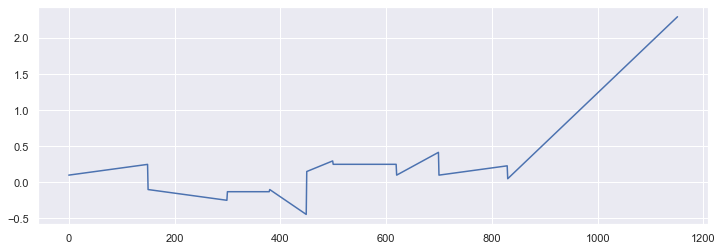

In [15]:
plt.plot([geo_market.phi(t) for t in range(1152)]);

#### Expected Perceived Value
A stock has an *expected perceived value* (EPV) associated with it. This is supposed to model what is elsewhere described as the *intrinsic value* or *fair value*. Since those concepts are rather weakly defined, we use the term EPV to express our ability to actually determine it's value by sampling (asking) a representative subset of investors. The EPV is modelled by a method called ```psi(t)``` or $\Psi(t)$. It considers all sentiments that we described above and involves some other rather arbitrary parameters, e.g. the expected compound annual growth rate. $\Psi(t)$ is modelled such that a constant sentiment of zero would lead to an exponential growth determined by that rate. With the help of some imagination you may indeed recognize the different sentiments described above.

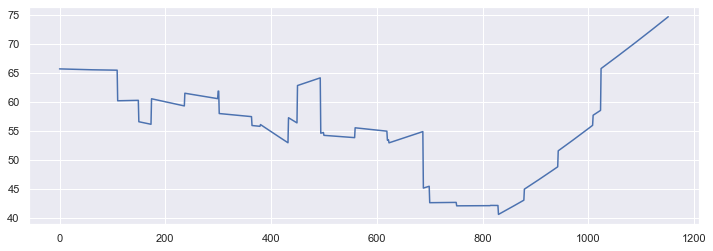

In [16]:
plt.plot([stock.psi(t) for t in range(1152)]);

#### Investors and the market
No market without investors. The investors that we introduce here, are simple heuristically motivated algorithmic traders that base their trading decision on momentum and value opportunities. Precisely, an ```Investor``` is an object that makes trade decisions based on the current price (in relation to the EPV) and the current momentum of the stocks. You find more details on Investors in [Market_with_Inertia.ipynb](Market_with_Inertia.ipynb). Investors always trade lots of 10 pieces.

In [17]:
from markets.dynamic_market import MomentumInvestor, Market

In [18]:
market = Market(stocks=list(stocks.values()), bid_ask=0.2) 
market.open()

In [19]:
tickers = list(stocks.keys())
print(tickers)
ticker = tickers[0]

['ISCR', 'OCOE', 'WAUT', 'HNEB', 'URQO', 'WXHG', 'STXD', 'WWBQ', 'UBYR', 'PYFC']


In [20]:
portfolio = {ticker: 10000 for ticker in tickers}

In [21]:
michael = MomentumInvestor(
    name="Michael Burry", 
    wealth=1000000, 
    portfolio=portfolio)

#### Investors act on the market

In [22]:
print("Michael's position in %s before acting: %s" % (ticker, michael.portfolio[ticker]))
print("Current prices (bid, ask): %s, %s" % market.price_for(ticker))

michael.act_on(market, ticker)
print()

print("Michael's position in %s after  acting: %s" % (ticker, michael.portfolio[ticker]))
print("Current prices (bid, ask): %s, %s" % market.price_for(ticker))

Michael's position in ISCR before acting: 10000
Current prices (bid, ask): 65.504, 65.104

Michael's position in ISCR after  acting: 9990
Current prices (bid, ask): 65.304, 64.904


You can see that the trade is executed at the bid or ask price, depending on what Michael did - sell or buy. You can also observe that as a consequence, prices will move up or down.

We will use this experimental setup employing more investors - each with a slightly different style - to generate synthetic price charts, that look as if they were taken from NYSE.

#### Chart data
The helper function ```create_chart_data(...)``` employs an investor model with a stochastic distribution of trading preferences. 

In [23]:
from markets.stocks_model import create_chart_data

In [24]:
config = {
    'num_investors': 10,
    'num_days': 128 + 1024, # 4 years with half a year of history
    'num_rounds_per_day': 5
}

In [25]:
chart_data = create_chart_data(stocks, config)

This takes a while, as we're simulating 4.5 years of 10 investors trading 10 stocks five times a day. Don't worry, though, here it should be over after a minute, at max.

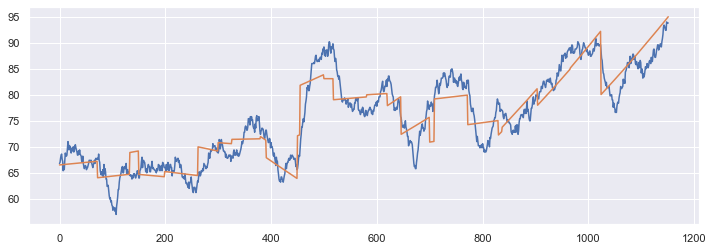

In [26]:
all_charts = np.array([chart_data[ticker]['price'] for ticker in stocks])
all_epv = np.array([chart_data[ticker]['epv'] for ticker in stocks])

ind = 3
plt.plot(all_charts[ind]);
plt.plot(all_epv[ind]);

## Using pre-produced data
Since the creation of market data takes such a long time, we'll be using pre-produced available in files. These files contain data of several different simulation runs. You can observe that the different runs produce very different data, although the *investors* are trading in exactly the same sentiment history. That's because the investors are created with random preferences for momentum and value and also their perception of the expected perceived value is modelled with some noise in it.

In [27]:
data = []
with open('charts.pkl', 'rb') as file:
    r=0
    while True:
        try: 
            data.append(pickle.load(file))
            r+=1
        except EOFError:
            print("Read %s samples." % r)
            break;


Read 2 samples.


Charts from two different simulation runs for the same sentiment history

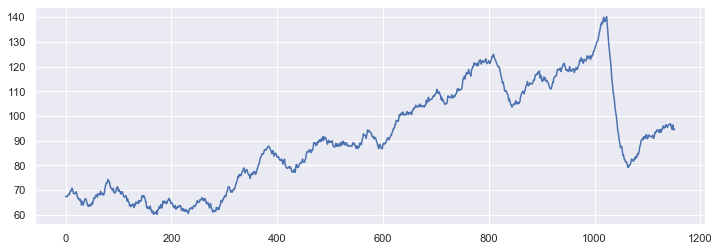

In [33]:
ticker = list(data[0].keys())[8]
plt.plot(data[0][ticker]['price']);
